In [1]:
import pandas as pd
from scipy.stats import norm, multivariate_normal
import numpy as np
from functools import reduce
import matplotlib as mpl
import matplotlib.pyplot as pyplot

# Some configuration
mpl.style.use('seaborn')
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

## Getting the data

In [2]:
def get_data():
    data = pd.read_csv('hw3_1.csv', header=None).transpose()
    return data

data = get_data()

In [3]:
data.head()

,0,1
0,-0.072801,-0.99431
1,1.052600,0.42878
2,0.988350,-0.59902
3,1.886100,-0.21998
4,0.645040,-1.30990


In [4]:
data.shape

(100, 2)

## Initial Parameters

In [5]:
def calc_cov_matrix(sample_vectors, mean_vector):
    """
    Params:
        sample_vector - list of Vectors ( n x 1 )
        mean_vector   - mean for each n ( n x 1)
    Returns
        scatter_matrix - Matrix ( n x n )
    """
    return reduce(lambda x, y: x+y, [np.outer(sample_vector - mean_vector, sample_vector - mean_vector) for sample_vector in sample_vectors]) / len(sample_vectors)


def calc_mean_vector(sample_vectors):
    """
    :param sample_vectors: list of np.array [ ( n x 1 ), ( n x 1 ), .., ( n x 1 ) ]
    :return: np.array - mean vector ( n x 1 )
    """
    # np.stack transforms the list into a multi-dimensional numpy array
    return np.stack(sample_vectors, axis=1).mean(axis=1)

In [6]:
# Split the data
g1 = data[:50]
g2 = data[50:]
# Get initial parameters
u1 = calc_mean_vector(g1.values)
c1 = calc_cov_matrix(g1.values, u1)
u2 = calc_mean_vector(g2.values)
c2 = calc_cov_matrix(g2.values, u2)

In [8]:
print('First Gaussian')
print('Mean Vector: {}'.format(u1))
print('Covariance matrix: {}'.format(list(c1)))

print('\nSecond Gaussian')
print('Mean Vector: {}'.format(u2))
print('Covariance matrix: {}'.format(list(c2)))

First Gaussian
Mean Vector: [0.566 -0.622]
Covariance matrix: [array([3.312, -0.948]), array([-0.948, 2.245])]

Second Gaussian
Mean Vector: [1.907 -1.408]
Covariance matrix: [array([6.358, -3.796]), array([-3.796, 7.380])]


Now we will wrap these methods into 1 function and return the starting distributions

In [12]:
def get_base_distributions(data):
    g1 = data[:50]
    g2 = data[50:]

    # MLE Parameters are the sample mean and sample covariance
    u1 = calc_mean_vector(g1.values)
    c1 = calc_cov_matrix(g1.values, u1)

    u2 = calc_mean_vector(g2.values)
    c2 = calc_cov_matrix(g2.values, u2)

    gauss1 = multivariate_normal(u1, c1)
    gauss2 = multivariate_normal(u2, c2)
    return gauss1, gauss2

In [13]:
gauss1, gauss2 = get_base_distributions(data)

## Expectation Step

We can now compute the likelihood for each sample indenpendently to determine which Gaussian it should belong to.

![Expectation](latex/exp_step3.PNG "E-Step")

For each sample, we compute the likelihood, multiplied by the weight of that gaussian. Then we normalize across both likelihoods so they sum to 1

r - is our responsibilities matrix that contains the likelihood for the gaussians based on each sample <br /> 
K - number of Gaussians (our case K=2) <br />
k - a particular gaussian (column) <br />
i - sample (row) <br />


In [14]:
def calc_expectation(data, gauss1, gauss2, pi):
    # E Stepb
    r = np.zeros((len(data), 2))
    for c, g, p in zip(range(2), [gauss1, gauss2], pi):
        r[:, c] = p * g.pdf(data)

    for i in range(len(r)):
        r[i] = r[i] / np.sum(r, axis=1)[i]

    # r is a matrix with a probability for each cluster (rows sum to 1)
    return r

In [15]:
rho = [0.5, 0.5]
r = calc_expectation(data, gauss1, gauss2, rho)

Here are the first 5 samples (each sample has 2 features)

In [16]:
data.values[:5]

array([[-0.073, -0.994],
       [1.053, 0.429],
       [0.988, -0.599],
       [1.886, -0.220],
       [0.645, -1.310]])

And here is the likelihood for each row to go to either the first Gaussian or Second

In [17]:
r[:5]

array([[0.737, 0.263],
       [0.654, 0.346],
       [0.699, 0.301],
       [0.627, 0.373],
       [0.702, 0.298]])

In [18]:
r.shape

(100, 2)

## Maximization Step

We need to re-calibrate the parameters for our two gaussians

### 1 - Rho (Gaussian Weight)

![RhoUpdate](latex/max_rho.PNG "M-Step")

In [19]:
def calc_total_weight(r):
    return r.sum(axis=0)


def calc_mixture(total_weight):
    # Parameter 1 (rho) Gaussian Mixture weighting
    return total_weight / total_weight.sum()

total_weight = calc_total_weight(r)
rho_u = calc_mixture(total_weight)

In [20]:
print('Original weighting: {}'.format(rho))
print('Updated  weighting: {}'.format(rho_u))

Original weighting: [0.5, 0.5]
Updated  weighting: [0.535 0.465]


### 2 - Mean vectors

![MaxMean](latex/max_mean.PNG "M-Step")

In [21]:
def calc_updated_mean(data, r, total_weight):
    # Parameter 2 (mean)
    mu_c = []
    for cluster, rho in zip(r.T, total_weight):
        mu_c.append((np.sum(data.multiply(cluster, axis=0)) / rho).values)
    return mu_c

mu_u = calc_updated_mean(data, r, total_weight)

In [22]:
print('First Gaussian')
print('Original Mean Vector: {}'.format(u1))
print('Updated  Mean Vector: {}'.format(mu_u[0]))
print('\nSecond Gaussian')
print('Original Mean Vector: {}'.format(u2))
print('Updated  Mean Vector: {}'.format(mu_u[1]))

First Gaussian
Original Mean Vector: [0.566 -0.622]
Updated  Mean Vector: [0.244 -0.278]

Second Gaussian
Original Mean Vector: [1.907 -1.408]
Updated  Mean Vector: [2.379 -1.865]


### 3 - Covariance Matrices 

![MaxCov](latex/max_cov.PNG "M-Step")

In [23]:
def calc_updated_cov(data, r, mu_u, total_weight):
    # Parameter 3 (covariance)
    d = data.values
    cov_c = []
    for cluster, u, w in zip(r.T, mu_u, total_weight):
        s = 0
        for n in range(len(d)):
            s += cluster[n]*np.outer(d[n] - u, d[n] - u)
        cov_c.append(s / w)
    return cov_c

cov_u = calc_updated_cov(data, r, mu_u, total_weight)

In [24]:
print('First Gaussian')
print('Original Covariance matrix: {}'.format(list(c1)))
print('Updated  Covariance matrix: {}'.format(list(cov_u[0])))
print('\nSecond Gaussian')
print('Original Covariance matrix: {}'.format(list(c2)))
print('Updated  Covariance matrix: {}'.format(list(cov_u[1])))

First Gaussian
Original Covariance matrix: [array([3.312, -0.948]), array([-0.948, 2.245])]
Updated  Covariance matrix: [array([1.993, -0.154]), array([-0.154, 1.182])]

Second Gaussian
Original Covariance matrix: [array([6.358, -3.796]), array([-3.796, 7.380])]
Updated  Covariance matrix: [array([6.636, -3.679]), array([-3.679, 7.977])]


Putting everything together, the maximization step can be wrapped into a function.

In [25]:
def calc_maximization(data, r):
    # M Step
    # Calculate total weight, then update parameters
    total_weight = calc_total_weight(r)
    rho_u = calc_mixture(total_weight)
    mu_u = calc_updated_mean(data, r, total_weight)
    cov_u = calc_updated_cov(data, r, mu_u, total_weight)
    return rho_u, mu_u, cov_u

# Stopping Criteria - Log-Likelihood 

![LLhood](latex/log_likelihood.PNG "Log Likelihood")

In [26]:
def evaluate_log_likelihood(data, gauss1, gauss2, rho_u):
    r_new = np.zeros((len(data), 3))
    for c, g, p in zip(range(2), [gauss1, gauss2], rho_u):
        r_new[:, c] = p * g.pdf(data)

    r_new[:, 2] = np.log(r_new[:, 0] + r_new[:, 1])
    log_likelihood = r_new[:, 2].sum()
    return log_likelihood

l_hood = evaluate_log_likelihood(data, gauss1, gauss2, rho)

# Visualization of GMM 

In [27]:
def plot_gmm(data, XY, gauss1, gauss2, title):
    d = data.values
    fig = pyplot.figure(figsize=(10, 10))
    ax0 = fig.add_subplot(111)
    ax0.scatter(d[:, 0], d[:, 1])
    ax0.set_title(title)
    ax0.contour(np.sort(d[:, 0]),
                np.sort(d[:, 1]),
                gauss1.pdf(XY).reshape(len(d), len(d)),
                colors='black',
                alpha=0.3)
    ax0.contour(np.sort(d[:, 0]),
                np.sort(d[:, 1]),
                gauss2.pdf(XY).reshape(len(d), len(d)),
                colors='black',
                alpha=0.3)
    pyplot.show()

def get_contour_grid_points(data):
    # Used for plotting the GMM
    d = data.values
    x, y = np.meshgrid(np.sort(d[:, 0]), np.sort(d[:, 1]))
    XY = np.array([x.flatten(), y.flatten()]).T
    return XY

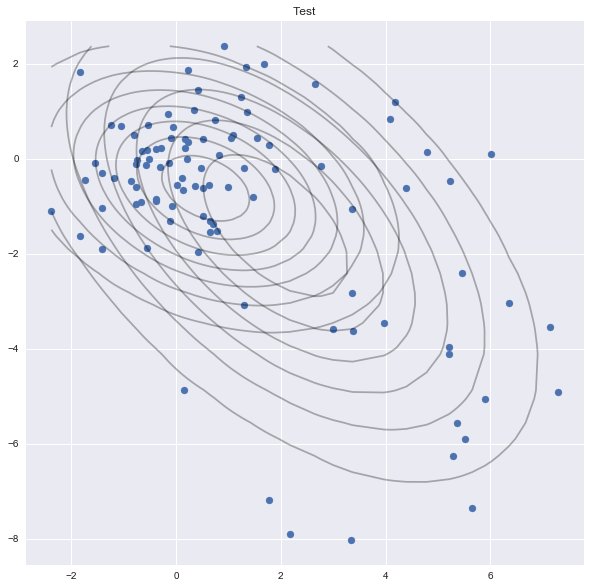

In [28]:
XY = get_contour_grid_points(data)
plot_gmm(data, XY, gauss1, gauss2, 'Test')

# EM Algorithm 

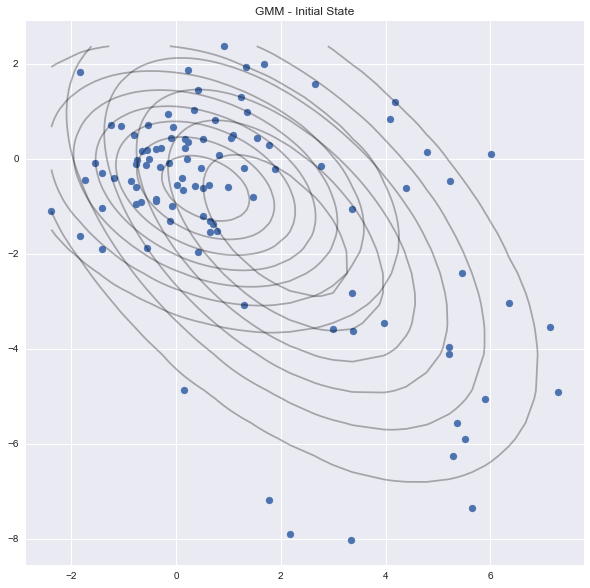

Log-Likelihood
01: Original: -418.313 Updated: -398.786, Difference: 19.527
02: Original: -398.786 Updated: -384.531, Difference: 14.255
03: Original: -384.531 Updated: -381.168, Difference: 3.363
04: Original: -381.168 Updated: -380.457, Difference: 0.711
05: Original: -380.457 Updated: -380.029, Difference: 0.428
06: Original: -380.029 Updated: -379.665, Difference: 0.364
07: Original: -379.665 Updated: -379.374, Difference: 0.291
08: Original: -379.374 Updated: -379.170, Difference: 0.204
09: Original: -379.170 Updated: -379.045, Difference: 0.125
10: Original: -379.045 Updated: -378.977, Difference: 0.068
11: Original: -378.977 Updated: -378.944, Difference: 0.033
12: Original: -378.944 Updated: -378.928, Difference: 0.015
13: Original: -378.928 Updated: -378.922, Difference: 0.007
14: Original: -378.922 Updated: -378.919, Difference: 0.003
15: Original: -378.919 Updated: -378.918, Difference: 0.001
16: Original: -378.918 Updated: -378.918, Difference: 0.000

Final Parameters:
rho:

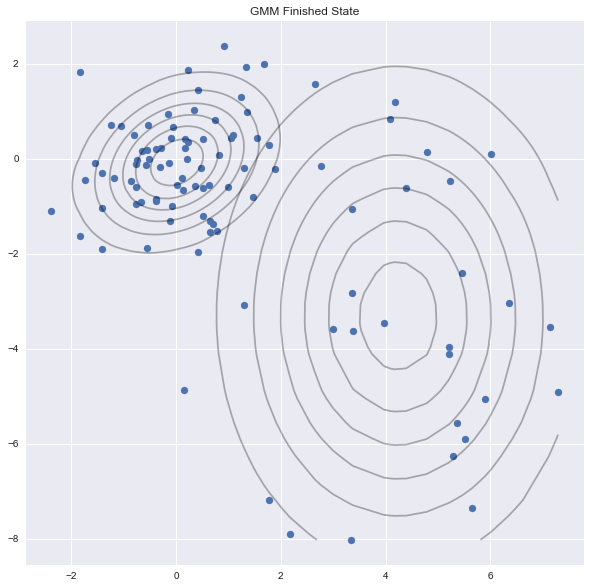

In [29]:
def em_for_mixed_gaussian(data, rho, epis, gmm_plot_data):

    # Step 1, calculate initial parameters using subset of data
    gauss1, gauss2 = get_base_distributions(data)

    # Plot Starting Gaussians
    plot_gmm(data, gmm_plot_data, gauss1, gauss2, 'GMM - Initial State')

    # Log Likelihood
    l_hood = evaluate_log_likelihood(data, gauss1, gauss2, rho)

    # Difference in Log Likelihood from two iterations
    d_hood = np.inf

    iteration = 1
    print('Log-Likelihood')
    while d_hood > epis:

        # Step 2, perform Expectation step
        r = calc_expectation(data, gauss1, gauss2, rho)

        # Step 3, perform Maximization step
        rho, mu_u, cov_u = calc_maximization(data, r)

        # Step 4 Check for convergence
        gauss1 = multivariate_normal(mu_u[0], cov_u[0])
        gauss2 = multivariate_normal(mu_u[1], cov_u[1])

        u_hood = evaluate_log_likelihood(data, gauss1, gauss2, rho)
        d_hood = np.abs(l_hood - u_hood)
        print('{0:02d}: Original: {1:0.3f} Updated: {2:0.03f}, Difference: {3:0.03f}'.format(iteration, l_hood, u_hood, d_hood))
        l_hood = u_hood
        iteration += 1

    print('\nFinal Parameters:')
    print('rho: {}'.format(rho))
    print('M1 - Mean: {}'.format(mu_u[0]))
    print('M2 - Mean: {}'.format(mu_u[1]))
    print('M1 - Covariance: {}'.format(list(cov_u[0])))
    print('M2 - Covariance: {}'.format(list(cov_u[1])))

    # Plot Finished GMM
    plot_gmm(data, gmm_plot_data, gauss1, gauss2, 'GMM Finished State')


data = get_data()
rho = [0.5, 0.5]
epis = .001  # Stopping Threshold
XY = get_contour_grid_points(data)
em_for_mixed_gaussian(data, rho, epis, XY)